#Unpacking Images, Imports and Load Network

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# desempacotamento de imagens em formato .zip
!unzip "/content/drive/MyDrive/PAC_CNN_DATASET/augmented_train.zip" -d "/content/" #train

Archive:  /content/drive/MyDrive/PAC_CNN_DATASET/augmented_train.zip
   creating: /content/augmented_train/
   creating: /content/augmented_train/images/
  inflating: /content/augmented_train/images/100.473.jpg  
  inflating: /content/augmented_train/images/107.84.jpg  
  inflating: /content/augmented_train/images/109.973.jpg  
  inflating: /content/augmented_train/images/114.833.jpg  
  inflating: /content/augmented_train/images/119.387.jpg  
  inflating: /content/augmented_train/images/127.88.jpg  
  inflating: /content/augmented_train/images/129.532.jpg  
  inflating: /content/augmented_train/images/131.977.jpg  
  inflating: /content/augmented_train/images/134.043.jpg  
  inflating: /content/augmented_train/images/135.637.jpg  
  inflating: /content/augmented_train/images/138.338.jpg  
  inflating: /content/augmented_train/images/138.73.jpg  
  inflating: /content/augmented_train/images/144.27.jpg  
  inflating: /content/augmented_train/images/161.82.jpg  
  inflating: /content/aug

In [3]:
# desempacotamento de imagens em formato .zip
!unzip "/content/drive/MyDrive/PAC_CNN_DATASET/augmented_test.zip" -d "/content/" #test

Archive:  /content/drive/MyDrive/PAC_CNN_DATASET/augmented_test.zip
   creating: /content/augmented_test/
   creating: /content/augmented_test/images/
  inflating: /content/augmented_test/images/101.217.jpg  
  inflating: /content/augmented_test/images/104.478.jpg  
  inflating: /content/augmented_test/images/125.983.jpg  
  inflating: /content/augmented_test/images/169.007.jpg  
  inflating: /content/augmented_test/images/22.713.jpg  
  inflating: /content/augmented_test/images/33.924.jpg  
  inflating: /content/augmented_test/images/36.583.jpg  
  inflating: /content/augmented_test/images/49.17.jpg  
  inflating: /content/augmented_test/images/51.691.jpg  
  inflating: /content/augmented_test/images/58.937.jpg  
  inflating: /content/augmented_test/images/59.763.jpg  
  inflating: /content/augmented_test/images/65.467.jpg  
  inflating: /content/augmented_test/images/83.822.jpg  
  inflating: /content/augmented_test/images/84.063.jpg  


In [4]:
# bibliotecas importantes para execução sem erro do fluxo de treinamento e análise de resultados
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, recall_score, precision_score, f1_score

In [5]:
# definição de shape da imagem
img_shape = (256,256,3)

In [6]:
# carregamento de rede pré-treinada 
base_model = tf.keras.applications.VGG16(input_shape=img_shape, include_top=False, weights='imagenet')

58889256/58889256 [==============================] - 2s 0us/step


In [7]:
# descongelamento dos pesos do modelo
base_model.trainable = True

In [8]:
#base_model.output

In [9]:
# transformação da última camada da arquitetura escolhida em vetor
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
global_average_layer

<KerasTensor: shape=(None, 512) dtype=float32 (created by layer 'global_average_pooling2d')>

#Camadas Extras

In [10]:
# Adiciona camadas Dense e Dropout extras no topo da arquitetura escolhida para potencializar o aprendizado do modelo e evitar overfitting.
Dense1 = tf.keras.layers.Dense(1024, activation='relu')(global_average_layer)
Drop1 = Dropout(0.2)(Dense1)
Dense2 = tf.keras.layers.Dense(512, activation='relu')(Drop1)
Drop2 = Dropout(0.2)(Dense2)
Dense3 = tf.keras.layers.Dense(256, activation='relu')(Drop2)
Drop3 = Dropout(0.2)(Dense3)
Dense4 = tf.keras.layers.Dense(128, activation='relu')(Drop3)
Drop4 = Dropout(0.2)(Dense4)
Dense5 = tf.keras.layers.Dense(64, activation='relu')(Drop4)
Drop5 = Dropout(0.2)(Dense5)
Dense6 = tf.keras.layers.Dense(32, activation='relu')(Drop5)
Drop6 = Dropout(0.2)(Dense6)
prediction_layer = tf.keras.layers.Dense(1, activation='linear')(Drop6)
model = tf.keras.models.Model(inputs = base_model.input, outputs = prediction_layer)

In [11]:
# exibe toda a arquitetura que será usada para treinamento
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [12]:
# compilação do modelo, definição da função de perda, otimizador e metrica de avaliação
model.compile(loss='mean_absolute_percentage_error', optimizer=Adam(learning_rate=0.0001))

#Separação Train, Val, Test

In [13]:
# divisão do conjunto de dados
TRAIN_PATH = '/content/augmented_train/images'
TEST_PATH = '/content/augmented_test/images'

#Treinamento

In [14]:
from glob import glob
from google.colab.patches import cv2_imshow
import cv2

In [15]:
import os
def load_train(path):
    X = []
    y = []
    for i in range(len(path)):
        img = glob(TRAIN_PATH + '/*.jpg')
        image = cv2.imread(img[i])
        label = float((os.listdir(TRAIN_PATH)[i].split('_')[-1]).split('.jpg')[0])
        X.append(image)
        y.append(label)
    return np.array(X), np.array(y)

def load_test(path):
    X = []
    y = []
    for i in range(len(path)):
        img = glob(TEST_PATH + '/*.jpg')
        image = cv2.imread(img[i])
        label = float((os.listdir(TEST_PATH)[i].split('_')[-1]).split('.jpg')[0])
        X.append(image)
        y.append(label)
    return np.array(X), np.array(y)

X_train, y_train = load_train(os.listdir(TRAIN_PATH))
#_train = X_train / 255.0
X_test, y_test = load_test(os.listdir(TEST_PATH))
#X_test = X_test / 255.0

Total de imagens: 320
Total de targets: 320



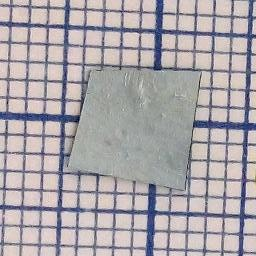

In [16]:
print(f'Total de imagens: {len(X_train)}\nTotal de targets: {len(y_train)}\n')
cv2_imshow(X_train[1])

In [17]:
y_train[1]

37.823

Total de imagens: 14
Total de targets: 14



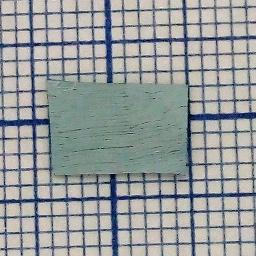

In [18]:
print(f'Total de imagens: {len(X_test)}\nTotal de targets: {len(y_test)}\n')
cv2_imshow(X_test[0])

In [19]:
y_test[0]

51.691

In [20]:
# definição de callback EarlyStopping para finalizar treinamento (model.fit) após 10 épocas sem melhora no desempenho, recuperando e salvando os melhores pesos
early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=150, mode="auto", restore_best_weights=True)

H = model.fit(x=X_train, y=y_train, epochs=500, validation_data=(X_test, y_test), callbacks=[early], batch_size=16)

Epoch 1/500
20/20 [==============================] - 20s 380ms/step - loss: 64.4496 - val_loss: 34.2176
Epoch 2/500
20/20 [==============================] - 6s 289ms/step - loss: 51.9167 - val_loss: 27.4596
Epoch 3/500
20/20 [==============================] - 6s 291ms/step - loss: 45.7713 - val_loss: 8.0711
Epoch 4/500
20/20 [==============================] - 6s 292ms/step - loss: 40.0055 - val_loss: 14.6307
Epoch 5/500
20/20 [==============================] - 6s 294ms/step - loss: 42.8057 - val_loss: 22.1400
Epoch 6/500
20/20 [==============================] - 6s 298ms/step - loss: 33.7787 - val_loss: 35.5958
Epoch 7/500
20/20 [==============================] - 6s 301ms/step - loss: 36.8480 - val_loss: 39.1140
Epoch 8/500
20/20 [==============================] - 6s 301ms/step - loss: 33.7976 - val_loss: 12.8197
Epoch 9/500
20/20 [==============================] - 6s 298ms/step - loss: 31.2627 - val_loss: 10.0749
Epoch 10/500
20/20 [==============================] - 6s 294ms/step - los

In [21]:
# predição do modelo no conjunto de teste
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

1/1 [==============================] - 0s 163ms/step


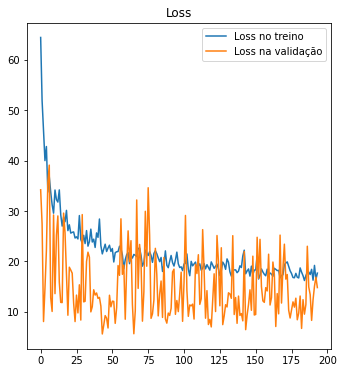

In [22]:
# exibição dos gráficos do treinamento e função de perda
loss = H.history['loss']
val_loss = H.history['val_loss']

plt.figure(figsize=(12,6))
plt.subplot(1, 2, 2)
plt.plot(range(len(loss)), loss, label='Loss no treino')
plt.plot(range(len(val_loss)), val_loss, label='Loss na validação')
plt.legend()
plt.title("Loss")

plt.show()

In [23]:
print(f'Maximum loss: {round(max(loss), 2)}\nMinimal loss: {round(min(loss), 2)}\n')
print(f'Maximum validation loss: {round(max(val_loss), 2)}\nMinimal validation loss : {round(min(val_loss), 2)}')

Maximum loss: 64.45
Minimal loss: 16.21

Maximum validation loss: 39.11
Minimal validation loss : 5.6


#Salva modelos

In [24]:
# salva estrutura do modelo
model_json = model.to_json()
with open("/content/drive/MyDrive/PAC_CNN_DATASET/models_h5_json/VGG16_240123.json", "w") as json_file:
    json_file.write(model_json)
# salva pesos do modelo em HDF5
model.save_weights("/content/drive/MyDrive/PAC_CNN_DATASET/models_h5_json/VGG16_240123.h5")
print("Saved model to disk")

Saved model to disk


In [25]:
# salva e carrega o modelo em .h5
from tensorflow.python.keras.models import load_model

model.save('/content/drive/MyDrive/PAC_CNN_DATASET/models_h5/VGG16_240123.h5')
print('Model Saved!')
 
# load model
#savedModel=load_model('79_49_Model_FRIGOBOM_2106.h5')
#savedModel.summary()

Model Saved!


#Inferência Individual por Imagem